## This notebook investigate large amps ripples and their mark (both 1D and 2D)
### These ripples with large amps cells tend to be fragmented. Here we investigate why.

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import spyglass as nd
import pandas as pd
# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import logging
import os
import cupy as cp

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

In [5]:
from spyglass.common import (Session, IntervalList,IntervalPositionInfo,
                             LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common.common_interval import _intersection
from spyglass.common.common_position import IntervalLinearizedPosition

import spyglass.spikesorting.v0 as ss
from spyglass.spikesorting.v0 import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,
                                   CuratedSpikeSortingSelection,CuratedSpikeSorting,Curation)
from spyglass.decoding.v0.clusterless import (UnitMarks,
                                           UnitMarkParameters,UnitMarksIndicatorSelection,
                                          UnitMarksIndicator)
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection

from replay_trajectory_classification.environments import Environment
from spyglass.common.common_position import TrackGraph
from spyglass.decoding.v0.clusterless import ClusterlessClassifierParameters
from replay_trajectory_classification import ClusterlessClassifier



import pprint
# Here are the analysis tables specific to Shijie Gu
from spyglass.shijiegu.Analysis_SGU import EpochPos,TrialChoice,Decode,TrialChoiceReplay,RippleTimes
from spyglass.shijiegu.decodeHelpers import (thresholder_sort,runSessionNames,populateUnitMarks,intersectValidIntervals)

[2024-06-26 14:52:46,694][INFO]: Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
26-Jun-24 14:52:46 Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[2024-06-26 14:52:46,753][INFO]: Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306
26-Jun-24 14:52:46 Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [6]:
from spyglass.shijiegu.decodeHelpers import decodePrepMasterSession

In [7]:
from spyglass.shijiegu.Analysis_SGU import EpochPos,ExtendedRippleTimes,DecodeIngredients

### 1. Plot `marks` (amplitude), compare between fragmented and cont decoding states

In [8]:
nwb_copy_file_name = 'eliot20221021_.nwb'

In [9]:
session_interval, position_interval = runSessionNames(nwb_copy_file_name)
print(session_interval)

['02_Seq2Session1', '04_Seq2Session2', '06_Seq2Session3', '08_Seq2Session4']


In [10]:
epoch_num = 8
key={'nwb_file_name':nwb_copy_file_name,'epoch':epoch_num}
epoch_name=(TrialChoice & key).fetch1('epoch_name')
print('epoch name',epoch_name)

epoch name 08_Seq2Session4


In [11]:
unitMarks = (UnitMarksIndicator & {
        'nwb_file_name': nwb_copy_file_name,
        'interval_list_name': position_interval[3]}).fetch_xarray()

In [12]:
# load marks
marks = xr.open_dataset((DecodeIngredients & {'nwb_file_name':
                                              nwb_copy_file_name,'interval_list_name':epoch_name}).fetch1('marks'))

In [16]:
ripple_times = pd.DataFrame((ExtendedRippleTimes & 
                             {'nwb_file_name': nwb_copy_file_name, 'interval_list_name': epoch_name}).fetch1('ripple_times'))

In [197]:
def findMaxChannelAmp(marks_subset,marks_e):
    eletrodes = np.unique(marks_subset.electrodes)
    for e in eletrodes:
        marks_subset_e = np.array(marks_subset.sel(electrodes = e).to_dataarray()).squeeze()
        valid_time_ind = np.sum(np.isnan(marks_subset_e[:,:,0]),axis=1)<4
        if len(valid_time_ind)==0:
            continue
        marks_subset_e = marks_subset_e[valid_time_ind,:,0]
        max_channel = np.nanargmin(marks_subset_e[:,:],axis = 1)
        marks_subset_e = np.array([marks_subset_e[t,max_channel[t]] for t in range(marks_subset_e.shape[0])])
        marks_subset_hist = marks_subset_e[~np.isnan(marks_subset_e)]
        marks_e[e].append(marks_subset_hist)
    return marks_e

In [198]:
eletrodes

array([ 0,  2,  4,  5, 13, 14, 16, 17, 20, 23, 26, 27, 28, 29, 30, 31],
      dtype=int32)

In [199]:
def RippleTimeMarkAmp(marks,ripple_times,fragFlag = True):
    eletrodes = np.unique(marks.electrodes)
    marks_e = {}
    for e in eletrodes:
        marks_e[e] = []
        
    for ripple_id in ripple_times.index:
        if fragFlag:
            intervals = ripple_times.loc[ripple_id].frag_intvl
        else:
            intervals = ripple_times.loc[ripple_id].cont_intvl
        
        for interval in intervals:
            marks_subset=marks.sel(
                        time=marks.time[
                            np.logical_and(marks.time>=interval[0],marks.time<=interval[1])])
            marks_e = findMaxChannelAmp(marks_subset,marks_e)
    return marks_e

In [200]:
marks_e_frag = RippleTimeMarkAmp(marks,ripple_times,fragFlag = True)
marks_e_cont = RippleTimeMarkAmp(marks,ripple_times,fragFlag = False)
for e in eletrodes:
    marks_e_frag[e] = np.concatenate(marks_e_frag[e])
    marks_e_cont[e] = np.concatenate(marks_e_cont[e])

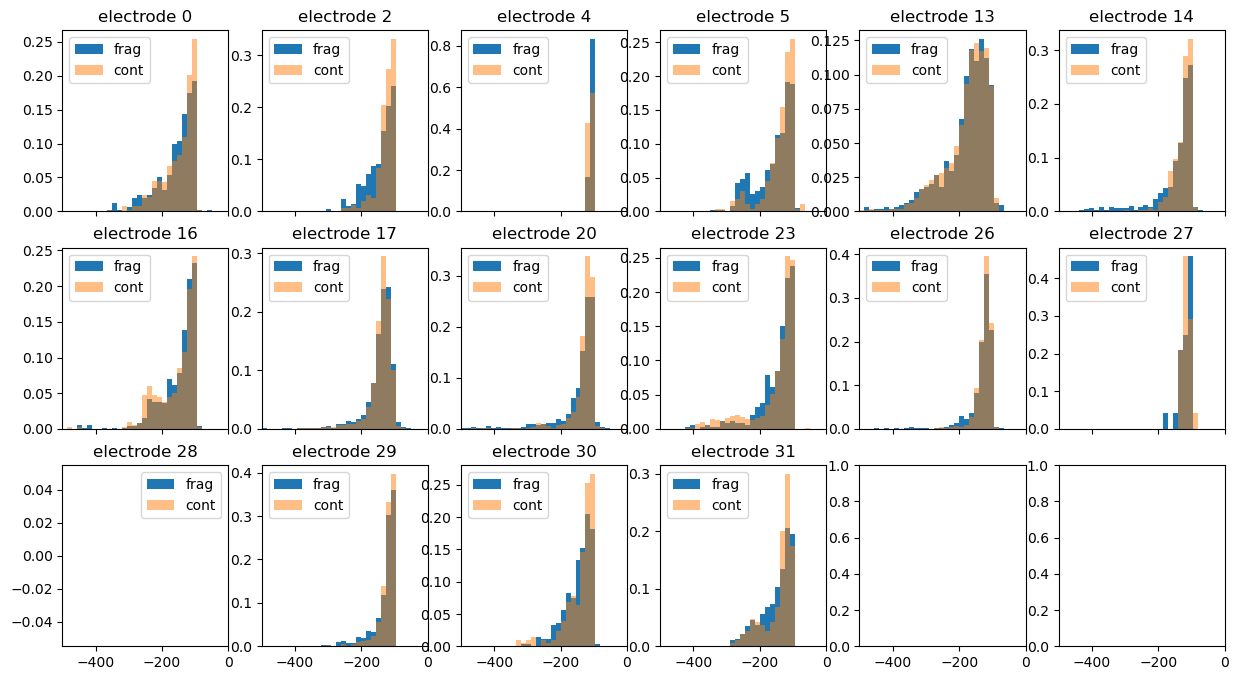

In [203]:
column_num = int(np.ceil(len(eletrodes)/3))
fig, axes = plt.subplots(3,column_num,figsize = (15,8),sharex = 1)
i = 0
for e in eletrodes:
    row = int(np.floor(i/column_num))
    col = i % column_num
    
    
    axes[row, col].hist(marks_e_frag[e], bins = np.arange(-500,0,15), weights = np.ones_like(marks_e_frag[e])*1/len(marks_e_frag[e]),label = 'frag')
    axes[row, col].hist(marks_e_cont[e], bins = np.arange(-500,0,15), weights = np.ones_like(marks_e_cont[e])*1/len(marks_e_cont[e]),alpha = 0.5,label = 'cont')
    axes[row, col].set_title('electrode '+str(e))
    axes[row, col].set_xlim([-500,0])
    axes[row, col].legend()
    i = i + 1

### 2. Plot waveform

In [204]:
from spyglass.spikesorting.v0.spikesorting_curation import (
    CuratedSpikeSorting,
    CuratedSpikeSortingSelection,
    Curation,
)
import uuid
from pathlib import Path
from spyglass.settings import waveforms_dir
import spikeinterface as si

In [ ]:
def RippleTime2Index(nwb_units,ripple_times,fragFlag = True):
    spike_times = nwb_units.spike_times[0]
    ind = []
        
    for ripple_id in ripple_times.index:
        if fragFlag:
            intervals = ripple_times.loc[ripple_id].frag_intvl
        else:
            intervals = ripple_times.loc[ripple_id].cont_intvl
        
        for interval in intervals:
            ind_subset=np.argwhere(
                np.logical_and(spike_times>=interval[0],spike_times<=interval[1])).ravel()
            ind.append(ind_subset)
    return np.concatenate(ind)

In [282]:
eletrode = 5

In [286]:
def findWaveForms(eletrode):
    key = {'nwb_file_name':nwb_copy_file_name,
           'sort_interval_name':epoch_name,
           'sort_group_id':eletrode,
           'artifact_removed_interval_list_name':
           f'eliot20221021_.nwb_08_Seq2Session4_{eletrode}_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}

    nwb_units = (CuratedSpikeSorting() & key).fetch_nwb()[0]["units"]

    recording = Curation.get_recording(key)
    if recording.get_num_segments() > 1:
        recording = si.concatenate_recordings([recording])
    sorting = Curation.get_curated_sorting(key)

    curation_id = (Curation & key).fetch1('curation_id')
    waveform_extractor_name = (
        f'{key["nwb_file_name"]}_{str(uuid.uuid4())[0:8]}_'
        f'{curation_id}_clusterless_waveforms'
    )
    waveform_extractor_path = str(
        Path(waveforms_dir) / Path(waveform_extractor_name)
    )

    WAVEFORM_PARAMS = {
    "ms_before": 0.5,
    "ms_after": 0.5,
    "max_spikes_per_unit": None,
    "n_jobs": 5,
    "total_memory": "5G",
    }
    waveform_extractor = si.extract_waveforms(
        recording=recording,
        sorting=sorting,
        folder=waveform_extractor_path,
        **WAVEFORM_PARAMS,
    )
    waveforms = waveform_extractor.get_waveforms(0)

    return nwb_units,waveforms

In [288]:
# extract waveform
nwb_units_all = {}
waveforms_all = {}
for e in eletrodes:
    nwb_units_all[e],waveforms_all[e] = findWaveForms(e)

extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

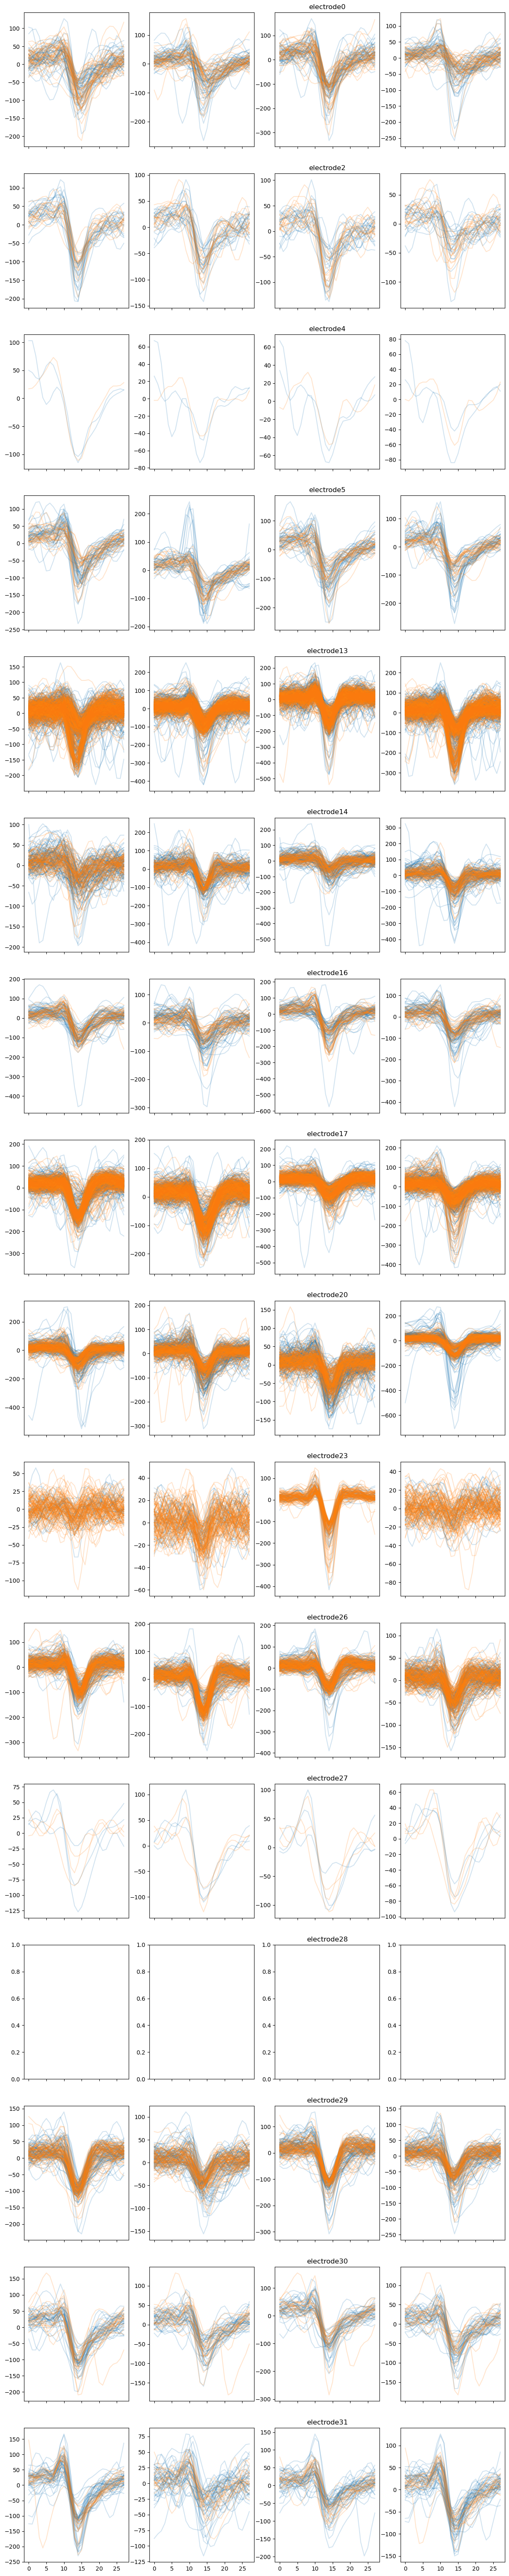

In [290]:
fig, axes = plt.subplots(len(eletrodes),4,figsize = (15,5*len(eletrodes)),sharex = 1)

row_ind = 0
for e in eletrodes:
    (nwb_units,waveforms) = (nwb_units_all[e],waveforms_all[e])
    ind_frag = RippleTime2Index(nwb_units,ripple_times,fragFlag = True)
    ind_cont = RippleTime2Index(nwb_units,ripple_times,fragFlag = False)

    (sample_num,clip_size,channel_num) = waveforms.shape
    
    for s_ind in range(0,len(ind_frag),10):
        s = ind_frag[s_ind]
        for ch in range(channel_num):
            axes[row_ind,ch].plot(waveforms[s,:,ch].squeeze(),'C0',alpha = 0.2)
    
    for s_ind in range(0,len(ind_cont),10):
        s = ind_cont[s_ind]
        for ch in range(channel_num):
            axes[row_ind,ch].plot(waveforms[s,:,ch].squeeze(),'C1',alpha = 0.2)
    axes[row_ind,2].set_title('electrode'+str(e))
    row_ind = row_ind + 1
    


### For just one electrode

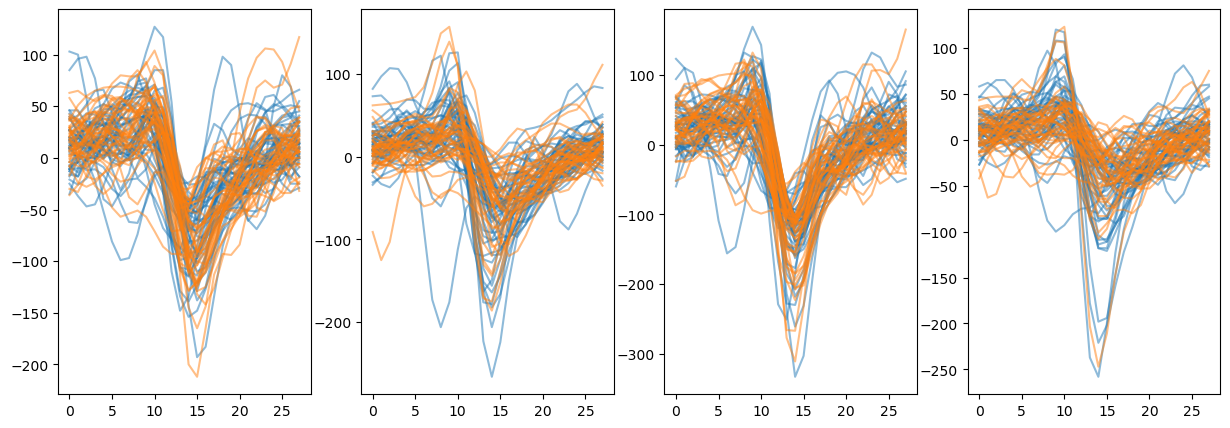

In [276]:
(sample_num,clip_size,channel_num) = waveforms.shape
fig, axes = plt.subplots(1,4,figsize = (15,5),sharex = 1)
for s_ind in range(0,len(ind_frag),10):
    s = ind_frag[s_ind]
    for ch in range(channel_num):
        axes[ch].plot(waveforms[s,:,ch].squeeze(),'C0',alpha = 0.5)

for s_ind in range(0,len(ind_cont),10):
    s = ind_cont[s_ind]
    for ch in range(channel_num):
        axes[ch].plot(waveforms[s,:,ch].squeeze(),'C1',alpha = 0.5)


### 3. Find spikes far from the Encoding model (spikes during run)

In [25]:
marks_electrode = np.array(marks.sel(electrodes = 5).to_array()).squeeze()[:,:,0]

#### (1) all of the marks

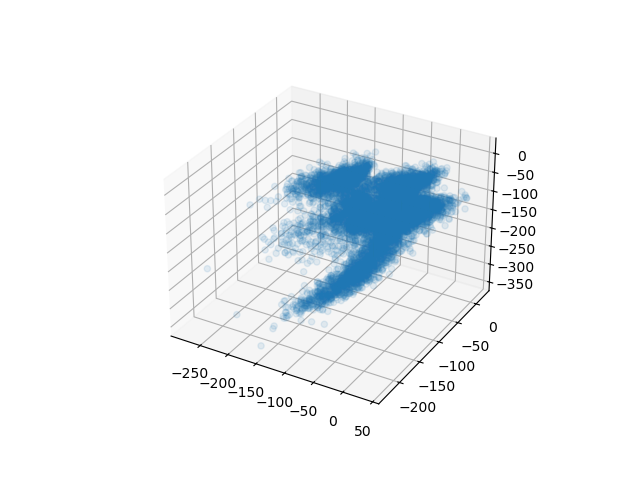

In [33]:
%matplotlib widget 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(marks_electrode[:,0],marks_electrode[:,1],marks_electrode[:,2],alpha=0.1)

#### (2) only the running time marks

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

In [847]:
epochNum = 3
epoch_name = '08_Seq2Session4'
entry = DecodeIngredients & {'nwb_file_name':nwb_copy_file_name,
         'interval_list_name':session_interval[epochNum]}
print(entry)

# Get data

# load marks
marks = xr.open_dataset(entry.fetch1('marks'))
position_1d = pd.read_csv(entry.fetch1('position_1d'))
position_2d = pd.read_csv(entry.fetch1('position_2d')) #still need 2D position

# choose movement data only to fit
mobility_ind = position_2d.head_speed >= 2
mark_mobility = marks.isel(time=np.argwhere(np.array(mobility_ind)).ravel())
#mark_mobility = marks.copy()

ripple_times = pd.DataFrame((RippleTimes & 
                             {'nwb_file_name': nwb_copy_file_name, 'interval_list_name': epoch_name}).fetch1('ripple_times'))


*nwb_file_name *interval_list marks      position_1 position_2
+------------+ +------------+ +--------+ +--------+ +--------+
eliot20221021_ 08_Seq2Session =BLOB=     =BLOB=     =BLOB=    
 (Total: 1)



In [848]:
# continous decode time marks
def RippleTimeMarkAmp(marks,ripple_times,fragFlag = False):
    eletrodes = np.unique(marks.electrodes)
    marks_e = {}
    for e in eletrodes:
        marks_e[e] = []
        
    for ripple_id in ripple_times.index:
        if fragFlag:
            intervals = ripple_times.loc[ripple_id].frag_intvl
        else:
            intervals = ripple_times.loc[ripple_id].cont_intvl
        
        for interval in intervals:
            marks_subset=marks.sel(
                        time=marks.time[
                            np.logical_and(marks.time>=interval[0],marks.time<=interval[1])])

            for e in eletrodes:
                mark_subset_electrode = marks_subset.sel(electrodes = e)
                
                mark_subset_electrode_np = np.array(mark_subset_electrode.to_dataarray()).squeeze()[:,:,0]
                
                marks_e[e].append(mark_subset_electrode_np)
    for e in eletrodes:
        marks_e[e] = np.concatenate(marks_e[e])
            
    return marks_e

In [878]:
# continous decode time marks
def NonRippleTimeMarkAmp(marks,ripple_times):
    ind_to_exclude = []
    
    for ripple_id in ripple_times.index:
        intervals = ripple_times.loc[ripple_id].frag_intvl
        for interval in intervals:
            ind = np.logical_and(np.array(marks.time)>=interval[0],np.array(marks.time)<=interval[1])
            ind_to_exclude.append(ind)

        intervals = ripple_times.loc[ripple_id].cont_intvl
        for interval in intervals:
            ind = np.logical_and(np.array(marks.time)>=interval[0],np.array(marks.time)<=interval[1])
            ind_to_exclude.append(ind)
    ind_to_exclude = np.concatenate(ind_to_exclude)
    ind_to_include = np.setdiff1d(np.arange(len(np.array(marks.time))),ind_to_exclude)
    marks_subset=marks.isel(time=ind_to_include)
            
    return marks_subset

In [849]:
def removeNan(data):
    notnan_ind = np.sum(np.isnan(data),axis = 1) < 4
    return data[notnan_ind,:].copy()
    

In [850]:
# continous decode time marks
marks_cont = RippleTimeMarkAmp(marks,ripple_times,fragFlag = False)

# fragmented decode time marks
marks_frag = RippleTimeMarkAmp(marks,ripple_times,fragFlag = True)

In [851]:
electrode = 20

In [879]:
# nonripple marks
mark_nonripple = NonRippleTimeMarkAmp(marks,ripple_times)

mark_nonripple_electrode = mark_nonripple.sel(electrodes = electrode)
mark_nonripple_electrode_np = np.array(mark_nonripple_electrode.to_dataarray()).squeeze()[:,:,0]

In [852]:
# encoding marks
mark_mobility_electrode = mark_mobility.sel(electrodes = electrode)
mark_mobility_electrode_np = np.array(mark_mobility_electrode.to_dataarray()).squeeze()[:,:,0]


In [853]:
marks_cont_electrode = removeNan(marks_cont[electrode])
marks_frag_electrode = removeNan(marks_frag[electrode])
mark_mobility_electrode_np = removeNan(mark_mobility_electrode_np)

In [854]:
dist_cont = pairwise_distances(marks_cont_electrode, mark_mobility_electrode_np, metric='euclidean')
dist_frag = pairwise_distances(marks_frag_electrode, mark_mobility_electrode_np, metric='euclidean')

In [855]:
dist_cont_min = np.min(dist_cont,axis = 1)
dist_frag_min = np.min(dist_frag,axis = 1)

In [856]:
kth = 5
dist_cont_kmin = np.mean(np.partition(dist_cont,kth = kth,axis = 1)[:,:kth],axis=1)
dist_frag_kmin = np.mean(np.partition(dist_frag,kth = kth,axis = 1)[:,:kth],axis=1)

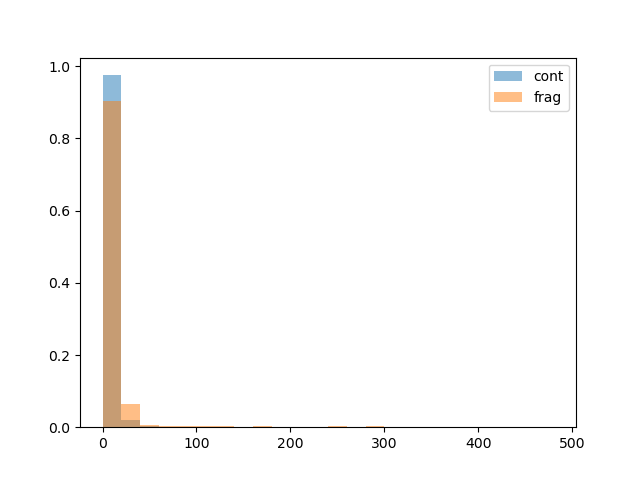

In [857]:
%matplotlib widget 
fig = plt.figure()
plt.hist(dist_cont_kmin,alpha = 0.5,
         bins = np.arange(0,500,20),
         weights = np.ones_like(dist_cont_kmin)*1/len(dist_cont_kmin),label = 'cont')
plt.hist(dist_frag_kmin,alpha = 0.5,
         bins = np.arange(0,500,20),
         weights = np.ones_like(dist_frag_kmin)*1/len(dist_frag_kmin),label = 'frag')
#plt.stairs(counts, bins)
plt.legend()

In [858]:
## Find the spikes that have fewer than x number of close (<100 distance) neighbors
FAR_THRESH = 20
CLOSE_THRESH = 20
far_ind_cont = np.argwhere(dist_cont_kmin >= FAR_THRESH).ravel()
far_ind_frag = np.argwhere(dist_frag_kmin >= FAR_THRESH).ravel()
close_ind_cont = np.argwhere(dist_cont_kmin < CLOSE_THRESH).ravel()
close_ind_frag = np.argwhere(dist_frag_kmin < CLOSE_THRESH).ravel()

In [859]:
import math

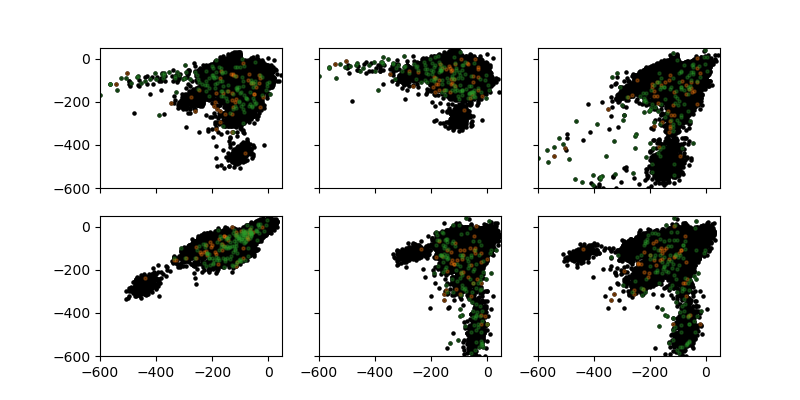

In [881]:
%matplotlib widget 
fig,axes = plt.subplots(2,3,figsize = (8,4),sharex = True,sharey = True)
#ax = fig.add_subplot(projection='3d')

data0 = mark_nonripple_electrode_np
data1 = marks_cont_electrode
data2 = marks_frag_electrode

ax_ind = 0
for p in [(0,1),(0,2),(0,3),(1,2),(2,3),(1,3)]:
    ch1 = p[0]
    ch2 = p[1]

    axes[math.floor(ax_ind/3),ax_ind%3].scatter(data0[:,ch1],
                                                data0[:,ch2],color = 'k',s=5, alpha=1)
    axes[math.floor(ax_ind/3),ax_ind%3].scatter(data1[far_ind_cont,ch1],
                                                data1[far_ind_cont,ch2],s=5,color = 'C1',alpha = 0.3)
    axes[math.floor(ax_ind/3),ax_ind%3].scatter(data2[far_ind_frag,ch1],
                                                data2[far_ind_frag,ch2],s=5,color = 'C2',alpha = 0.3)
    #axes[math.floor(ax_ind/3),ax_ind%3].scatter(mark_mobility_electrode_np[:,ch1],
    #                                            mark_mobility_electrode_np[:,ch2],color = 'k',s=5, alpha=1)
    
    axes[math.floor(ax_ind/3),ax_ind%3].set_xlim([-600,50])
    axes[math.floor(ax_ind/3),ax_ind%3].set_ylim([-600,50])
    
    ax_ind += 1

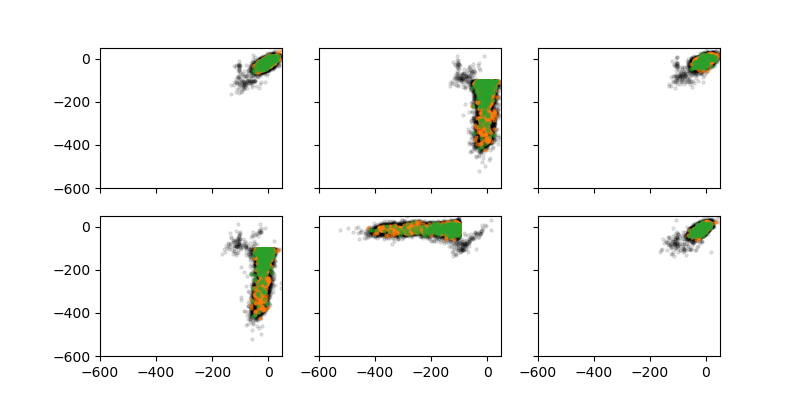

In [781]:
%matplotlib widget 
fig,axes = plt.subplots(2,3,figsize = (8,4),sharex = True,sharey = True)
#ax = fig.add_subplot(projection='3d')

data1 = marks_cont_electrode
data2 = marks_frag_electrode

ax_ind = 0
for p in [(0,1),(0,2),(0,3),(1,2),(2,3),(1,3)]:
    ch1 = p[0]
    ch2 = p[1]
    
    axes[math.floor(ax_ind/3),ax_ind%3].scatter(mark_mobility_electrode_np[:,ch1], mark_mobility_electrode_np[:,ch2],s=5, color = 'k',alpha=0.1)
    axes[math.floor(ax_ind/3),ax_ind%3].scatter(data1[close_ind_cont,ch1],data1[close_ind_cont,ch2],s=5,color = 'C1',alpha = 0.5)
    axes[math.floor(ax_ind/3),ax_ind%3].scatter(data2[close_ind_frag,ch1],data2[close_ind_frag,ch2],s=5,color = 'C2',alpha = 0.5)
    
    axes[math.floor(ax_ind/3),ax_ind%3].set_xlim([-600,50])
    axes[math.floor(ax_ind/3),ax_ind%3].set_ylim([-600,50])
    ax_ind += 1

In [ ]:
DecodeIngredients() & key

In [33]:
positionIntervalList = (
        IntervalList &
        {'nwb_file_name': nwb_copy_file_name,
         'interval_list_name': position_interval[e]})

marks_selection = ((UnitMarks & mark_parameters_keys) * positionIntervalList)
marks_selection = (pd.DataFrame(marks_selection)
                   .loc[:, marks_selection.primary_key]
                   .to_dict('records'))
UnitMarksIndicatorSelection.insert(marks_selection, skip_duplicates=True)

In [34]:
UnitMarksIndicatorSelection() & {'nwb_file_name': nwb_copy_file_name,
         'interval_list_name': position_interval[e]}

*curation_id   *nwb_file_name *sort_group_id *sort_interval *preproc_param *team_name    *sorter        *sorter_params *artifact_remo *mark_param_na *interval_list *sampling_rate
+------------+ +------------+ +------------+ +------------+ +------------+ +-----------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+
0              eliot20221026_ 0              06_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221026_ default        pos 5 valid ti 500.0         
0              eliot20221026_ 2              06_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221026_ default        pos 5 valid ti 500.0         
0              eliot20221026_ 4              06_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221026_ default        pos 5 valid ti 500.0         
0              eliot20221026_ 5              06_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221026_ default        pos 5 valid ti 500.0         
0              eliot20221026_ 13             06_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221026_ default        pos 5 valid ti 500.0         
0              eliot20221026_ 14             06_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221026_ default        pos 5 valid ti 500.0         
0              eliot20221026_ 16             06_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221026_ default        pos 5 valid ti 500.0         
0              eliot20221026_ 17             06_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221026_ default        pos 5 valid ti 500.0         
0              eliot20221026_ 20             06_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221026_ default        pos 5 valid ti 500.0         
0              eliot20221026_ 26             06_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221026_ default        pos 5 valid ti 500.0         
0              eliot20221026_ 27             06_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221026_ default        pos 5 valid ti 500.0         
0              eliot20221026_ 28             06_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221026_ default        pos 5 valid ti 500.0         
   ...
 (Total: 15)

In [35]:
UnitMarksIndicator.populate(marks_selection)

[11:06:29][INFO] Spyglass: Writing new NWB file eliot20221026_7TPPIRYHHH.nwb
13-Jun-24 11:06:29 Writing new NWB file eliot20221026_7TPPIRYHHH.nwb
[11:06:39][INFO] Spyglass: Writing new NWB file eliot20221026_SFUUZ8RY6O.nwb
13-Jun-24 11:06:39 Writing new NWB file eliot20221026_SFUUZ8RY6O.nwb
[11:06:50][INFO] Spyglass: Writing new NWB file eliot20221026_0V6U6VYUVH.nwb
13-Jun-24 11:06:50 Writing new NWB file eliot20221026_0V6U6VYUVH.nwb
[11:06:59][INFO] Spyglass: Writing new NWB file eliot20221026_UAMIWDZTKI.nwb
13-Jun-24 11:06:59 Writing new NWB file eliot20221026_UAMIWDZTKI.nwb
[11:07:09][INFO] Spyglass: Writing new NWB file eliot20221026_1C3YXY3ARC.nwb
13-Jun-24 11:07:09 Writing new NWB file eliot20221026_1C3YXY3ARC.nwb
[11:07:20][INFO] Spyglass: Writing new NWB file eliot20221026_R8CXFFFB1O.nwb
13-Jun-24 11:07:20 Writing new NWB file eliot20221026_R8CXFFFB1O.nwb
[11:07:29][INFO] Spyglass: Writing new NWB file eliot20221026_ETFUVPVM1G.nwb
13-Jun-24 11:07:29 Writing new NWB file eliot20

In [40]:
marks = (UnitMarksIndicator & {
    'nwb_file_name': nwb_copy_file_name,
    'interval_list_name': position_interval[e],   
}).fetch_xarray()
marks.shape

(850920, 4, 15)

After you get the marks, it is important to visualize them to make sure they look right. We can use the `plot_all_marks` method of UnitMarksIndicator to quickly plot each mark feature against the other for each electrode.

Here it is important to look for things that look overly correlated (strong diagonal on the off-diagonal plots) and for extreme amplitudes.

In [60]:
UnitMarksIndicator & {
    'nwb_file_name': nwb_copy_file_name  
}

*curation_id   *nwb_file_name *sort_group_id *sort_interval *preproc_param *team_name    *sorter        *sorter_params *artifact_remo *mark_param_na *interval_list *sampling_rate analysis_file_ marks_indicato
+------------+ +------------+ +------------+ +------------+ +------------+ +-----------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+
0              eliot20221021_ 0              02_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221021_ default        pos 1 valid ti 500.0          eliot20221021_ 2cc12b9c-36c3-
0              eliot20221021_ 0              02_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221021_ default        pos 1 valid ti 500.0          eliot20221021_ e0756d8a-ec68-
0              eliot20221021_ 0              04_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221021_ default        pos 3 valid ti 500.0          eliot20221021_ 2830f6ce-3e0d-
0              eliot20221021_ 0              04_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221021_ default        pos 3 valid ti 500.0          eliot20221021_ f9468067-942f-
0              eliot20221021_ 0              06_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221021_ default        pos 5 valid ti 500.0          eliot20221021_ 8cdabffd-dafd-
0              eliot20221021_ 0              06_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221021_ default        pos 5 valid ti 500.0          eliot20221021_ aca05b4e-4f53-
0              eliot20221021_ 0              08_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221021_ default        pos 7 valid ti 500.0          eliot20221021_ 19d1e9dd-ad97-
0              eliot20221021_ 0              08_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221021_ default        pos 7 valid ti 500.0          eliot20221021_ e1b06fa3-a2be-
0              eliot20221021_ 2              02_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221021_ default        pos 1 valid ti 500.0          eliot20221021_ 0b4462e7-2f78-
0              eliot20221021_ 2              02_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221021_ default        pos 1 valid ti 500.0          eliot20221021_ 87278124-ae40-
0              eliot20221021_ 2              04_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221021_ default        pos 3 valid ti 500.0          eliot20221021_ 60f43ad9-362c-
0              eliot20221021_ 2              04_Seq2Session franklab_tetro Shijie Gu     clusterless_th default        eliot20221021_ default        pos 3 valid ti 500.0          eliot20221021_ 20ebbc56-4b4c-
   ...
 (Total: 128)

## 2. Position

After the marks look good, you'll need to load/populate the 2D position data. This comes from the `IntervalPositionInfo` table. See the position tutorial for more information. Note that we will need to upsample the position data (which is done here via the `default_decoding` parameters) to match the sampling frequency that we intend to decode in (2 ms time bins or 500 Hz sampling rate)

Next we populate/load the linearized position tables. Again refer to the linear position tutorials for more information.

In [47]:
position_df = (IntervalPositionInfo &
 {'nwb_file_name': nwb_copy_file_name,
  'interval_list_name': position_interval[e],
  'position_info_param_name': 'default_decoding'}
              ).fetch1_dataframe()

In [48]:
position_df

head_position_x  head_position_y  head_orientation  \
time                                                               
1.666816e+09           210.00       231.000000          1.403169   
1.666816e+09           210.00       231.000000          1.570382   
1.666816e+09           210.00       231.000000          1.570796   
1.666816e+09           210.00       231.000000          1.570796   
1.666816e+09           210.00       231.000000          1.570796   
...                       ...              ...               ...   
1.666818e+09           315.25       108.960227         -0.086802   
1.666818e+09           315.25       108.954545         -0.085213   
1.666818e+09           315.25       108.948864         -0.083627   
1.666818e+09           315.25       108.943182         -0.043893   
1.666818e+09           315.25       108.937500          2.783259   

              head_velocity_x  head_velocity_y  head_speed  
time                                                        
1.666816e+09    -4.183106e-10        -0.051216    0.051216  
1.666816e+09    -4.765132e-10        -0.055574    0.055574  
1.666816e+09    -5.425989e-10        -0.059933    0.059933  
1.666816e+09    -6.176049e-10        -0.064283    0.064283  
1.666816e+09    -7.027008e-10        -0.068615    0.068615  
...                       ...              ...         ...  
1.666818e+09    -1.014436e+00        -1.375576    1.709178  
1.666818e+09    -9.914567e-01        -1.354222    1.678364  
1.666818e+09    -9.686190e-01        -1.332783    1.647584  
1.666818e+09    -9.459378e-01        -1.311275    1.616861  
1.666818e+09    -9.234274e-01        -1.289715    1.586217  

[850920 rows x 6 columns]

In [38]:
from spyglass.common.common_position import IntervalLinearizedPosition

linear_position_df = (IntervalLinearizedPosition() &
 {'nwb_file_name': nwb_copy_file_name,
  'interval_list_name': position_interval[e],
  'position_info_param_name': 'default_decoding'}
).fetch1_dataframe()

linear_position_df

[11:38:54][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
13-Jun-24 11:38:54 Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


linear_position  track_segment_id  projected_x_position  \
time                                                                    
1.666816e+09         2.975418                 0            210.456487   
1.666816e+09         2.975418                 0            210.456487   
1.666816e+09         2.975418                 0            210.456487   
1.666816e+09         2.975418                 0            210.456487   
1.666816e+09         2.975418                 0            210.456487   
...                       ...               ...                   ...   
1.666818e+09       743.032159                 9            310.500000   
1.666818e+09       743.032159                 9            310.500000   
1.666818e+09       743.032159                 9            310.500000   
1.666818e+09       743.032159                 9            310.500000   
1.666818e+09       743.032159                 9            310.500000   

              projected_y_position  
time                                
1.666816e+09            231.031756  
1.666816e+09            231.031756  
1.666816e+09            231.031756  
1.666816e+09            231.031756  
1.666816e+09            231.031756  
...                            ...  
1.666818e+09            110.750000  
1.666818e+09            110.750000  
1.666818e+09            110.750000  
1.666818e+09            110.750000  
1.666818e+09            110.750000  

[850920 rows x 4 columns]

We should also quickly visualize the linear position in order to sanity check the values. Here we plot the 2D position projected to its corresponding 1D segment.

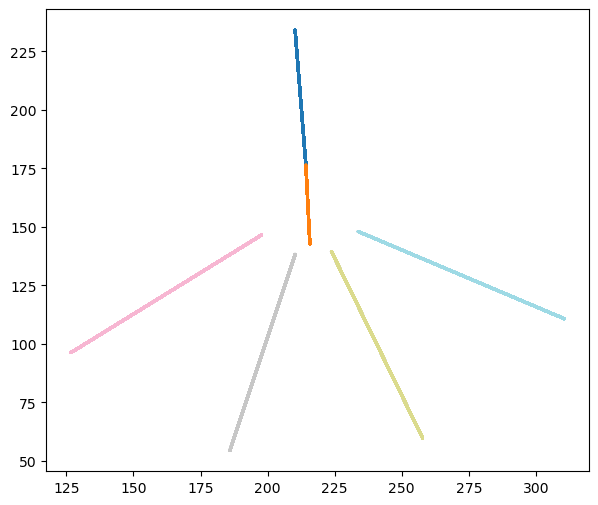

In [110]:
plt.figure(figsize=(7, 6))
plt.scatter(linear_position_df.projected_x_position, linear_position_df.projected_y_position,
            c=linear_position_df.track_segment_id, cmap='tab20', s=1)

We should also plot the linearized position itself to make sure it is okay.

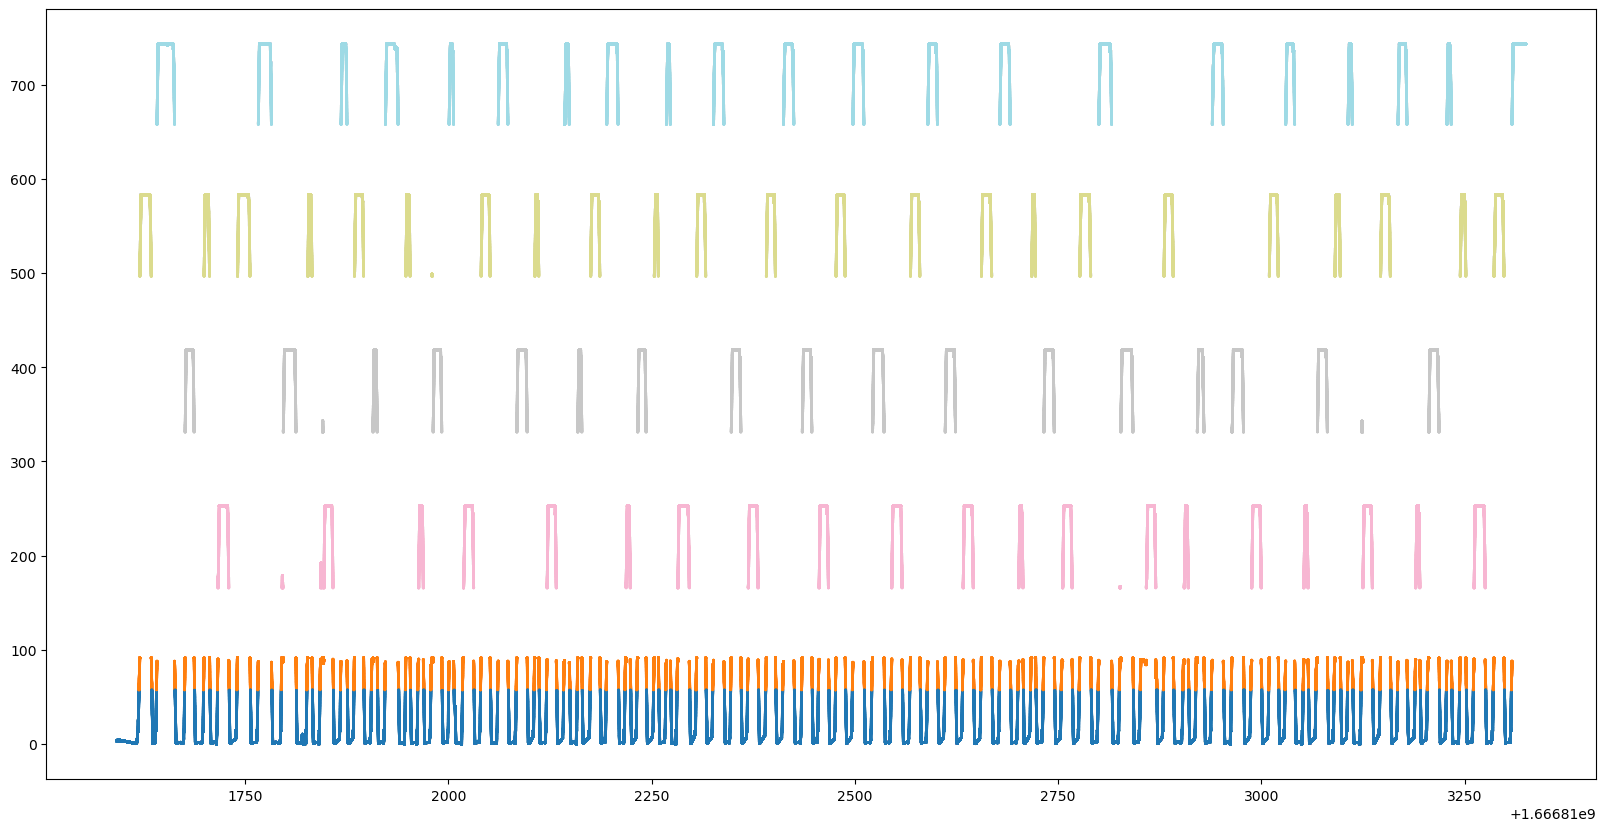

In [111]:
plt.figure(figsize=(20, 10))
plt.scatter(linear_position_df.index, linear_position_df.linear_position, s=1,
            c=linear_position_df.track_segment_id, cmap='tab20')

Okay now that we've looked at the data, we should quickly verify that all our data is the same size.

We also want to make sure we have valid ephys data and valid position data for decoding. Here we only have one valid time interval, but if we had more than one, we should decode on each interval separately.

In [50]:
intersect_interval = intersectValidIntervals(nwb_copy_file_name,
                                                session_interval[e],position_interval[e])
marks_=[]
linear_position_df_=[]
position_df_ =[]
for i in range(len(intersect_interval)):
    valid_time_slice = slice(intersect_interval[i][0], intersect_interval[i][1])
    
    linear_position_df_.append(linear_position_df.loc[valid_time_slice])
    position_df_.append(position_df.loc[valid_time_slice])
    marks_.append(marks.sel(time=valid_time_slice))

marks=xr.concat(marks_,dim='time')
position_df = pd.concat(position_df_)
linear_position_df=pd.concat(linear_position_df_)
marks.shape, position_df.shape, linear_position_df.shape

((818187, 4, 15), (818187, 6), (818187, 4))

In [52]:
animal = nwb_copy_file_name[:5]
marks_path=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',
                             nwb_copy_file_name+'_'+session_interval[e]+'_marks.nc')
marks.to_netcdf(marks_path)

position1d_path=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',
                             nwb_copy_file_name+'_'+session_interval[e]+'_1dposition.csv')
linear_position_df.to_csv(position1d_path)

position2d_path=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',
                             nwb_copy_file_name+'_'+session_interval[e]+'_2dposition.csv')
position_df.to_csv(position2d_path)

In [55]:
from spyglass.shijiegu.Analysis_SGU import DecodeIngredients
key={'nwb_file_name':nwb_copy_file_name,
     'interval_list_name':session_interval[e],
     'marks':marks_path,
     'position_1d':position1d_path,
     'position_2d':position2d_path}
DecodeIngredients().insert1(key,replace=True)

# Run All sessions

In [92]:
session_interval, position_interval = runSessionNames(nwb_copy_file_name)
print(nwb_copy_file_name)

eliot20221024_.nwb


In [ ]:
for e in range(len(session_interval)):
    decodePrepMasterSession(nwb_copy_file_name,e)

0
inserting into IntervalList
done inserting into IntervalList
2
inserting into IntervalList
done inserting into IntervalList
4
inserting into IntervalList
done inserting into IntervalList
5
inserting into IntervalList
done inserting into IntervalList
13
inserting into IntervalList
done inserting into IntervalList
14
inserting into IntervalList
done inserting into IntervalList
16
inserting into IntervalList
done inserting into IntervalList
17
inserting into IntervalList
done inserting into IntervalList
20
inserting into IntervalList
done inserting into IntervalList
26
inserting into IntervalList
done inserting into IntervalList
27
inserting into IntervalList
done inserting into IntervalList
28
inserting into IntervalList
done inserting into IntervalList
29
inserting into IntervalList
done inserting into IntervalList
30
inserting into IntervalList
done inserting into IntervalList
31
inserting into IntervalList
done inserting into IntervalList


[15:47:46][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 0, 'sort_interval_name': '02_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_02_Seq2Session2_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Jun-24 15:47:46 Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 0, 'sort_interval_name': '02_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_02_Seq2Session2_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...


detect peaks using locally_exclusive:   0%|          | 0/1730 [00:00<?, ?it/s]

[15:47:50][INFO] Spyglass: Saving sorting results...
20-Jun-24 15:47:50 Saving sorting results...
[15:47:54][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 2, 'sort_interval_name': '02_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_02_Seq2Session2_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Jun-24 15:47:54 Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 2, 'sort_interval_name': '02_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_02_Seq2Session2_2_franklab_tetrode_hippocampus_ampl_1500_prop_07

detect peaks using locally_exclusive:   0%|          | 0/1730 [00:00<?, ?it/s]

[15:47:57][INFO] Spyglass: Saving sorting results...
20-Jun-24 15:47:57 Saving sorting results...
[15:48:00][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 4, 'sort_interval_name': '02_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_02_Seq2Session2_4_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Jun-24 15:48:00 Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 4, 'sort_interval_name': '02_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_02_Seq2Session2_4_franklab_tetrode_hippocampus_ampl_1500_prop_07

detect peaks using locally_exclusive:   0%|          | 0/1730 [00:00<?, ?it/s]

[15:48:04][INFO] Spyglass: Saving sorting results...
20-Jun-24 15:48:04 Saving sorting results...
[15:48:07][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 5, 'sort_interval_name': '02_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_02_Seq2Session2_5_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Jun-24 15:48:07 Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 5, 'sort_interval_name': '02_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_02_Seq2Session2_5_franklab_tetrode_hippocampus_ampl_1500_prop_07

detect peaks using locally_exclusive:   0%|          | 0/1730 [00:00<?, ?it/s]

[15:48:11][INFO] Spyglass: Saving sorting results...
20-Jun-24 15:48:11 Saving sorting results...
[15:48:13][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 13, 'sort_interval_name': '02_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_02_Seq2Session2_13_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Jun-24 15:48:13 Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 13, 'sort_interval_name': '02_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_02_Seq2Session2_13_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1730 [00:00<?, ?it/s]

[15:48:17][INFO] Spyglass: Saving sorting results...
20-Jun-24 15:48:17 Saving sorting results...
[15:48:21][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 14, 'sort_interval_name': '02_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_02_Seq2Session2_14_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Jun-24 15:48:21 Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 14, 'sort_interval_name': '02_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_02_Seq2Session2_14_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1730 [00:00<?, ?it/s]

[15:48:24][INFO] Spyglass: Saving sorting results...
20-Jun-24 15:48:24 Saving sorting results...
[15:48:26][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 16, 'sort_interval_name': '02_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_02_Seq2Session2_16_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Jun-24 15:48:26 Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 16, 'sort_interval_name': '02_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_02_Seq2Session2_16_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1730 [00:00<?, ?it/s]

[15:48:30][INFO] Spyglass: Saving sorting results...
20-Jun-24 15:48:30 Saving sorting results...
[15:48:33][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 17, 'sort_interval_name': '02_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_02_Seq2Session2_17_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Jun-24 15:48:33 Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 17, 'sort_interval_name': '02_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_02_Seq2Session2_17_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1730 [00:00<?, ?it/s]

[15:48:37][INFO] Spyglass: Saving sorting results...
20-Jun-24 15:48:37 Saving sorting results...
[15:48:42][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 20, 'sort_interval_name': '02_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_02_Seq2Session2_20_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Jun-24 15:48:42 Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 20, 'sort_interval_name': '02_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_02_Seq2Session2_20_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1730 [00:00<?, ?it/s]

[15:48:46][INFO] Spyglass: Saving sorting results...
20-Jun-24 15:48:46 Saving sorting results...
[15:48:48][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 26, 'sort_interval_name': '02_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_02_Seq2Session2_26_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Jun-24 15:48:48 Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 26, 'sort_interval_name': '02_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_02_Seq2Session2_26_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1730 [00:00<?, ?it/s]

[15:48:51][INFO] Spyglass: Saving sorting results...
20-Jun-24 15:48:51 Saving sorting results...
[15:48:54][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 27, 'sort_interval_name': '02_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_02_Seq2Session2_27_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Jun-24 15:48:54 Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 27, 'sort_interval_name': '02_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_02_Seq2Session2_27_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1730 [00:00<?, ?it/s]

[15:48:59][INFO] Spyglass: Saving sorting results...
20-Jun-24 15:48:59 Saving sorting results...
[15:49:01][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 28, 'sort_interval_name': '02_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_02_Seq2Session2_28_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Jun-24 15:49:01 Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 28, 'sort_interval_name': '02_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_02_Seq2Session2_28_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1730 [00:00<?, ?it/s]

[15:49:05][INFO] Spyglass: Saving sorting results...
20-Jun-24 15:49:05 Saving sorting results...
[15:49:09][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 29, 'sort_interval_name': '02_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_02_Seq2Session2_29_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Jun-24 15:49:09 Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 29, 'sort_interval_name': '02_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_02_Seq2Session2_29_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1730 [00:00<?, ?it/s]

[15:49:11][INFO] Spyglass: Saving sorting results...
20-Jun-24 15:49:11 Saving sorting results...
[15:49:15][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 30, 'sort_interval_name': '02_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_02_Seq2Session2_30_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Jun-24 15:49:15 Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 30, 'sort_interval_name': '02_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_02_Seq2Session2_30_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1730 [00:00<?, ?it/s]

[15:49:18][INFO] Spyglass: Saving sorting results...
20-Jun-24 15:49:18 Saving sorting results...
[15:49:21][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 31, 'sort_interval_name': '02_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_02_Seq2Session2_31_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Jun-24 15:49:21 Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 31, 'sort_interval_name': '02_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_02_Seq2Session2_31_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1730 [00:00<?, ?it/s]

[15:49:24][INFO] Spyglass: Saving sorting results...
20-Jun-24 15:49:24 Saving sorting results...
[15:50:35][INFO] Spyglass: Found 1 accepted units
20-Jun-24 15:50:35 Found 1 accepted units
[15:50:41][INFO] Spyglass: Writing new NWB file eliot20221024_7D02VS5ABY.nwb
20-Jun-24 15:50:41 Writing new NWB file eliot20221024_7D02VS5ABY.nwb
[15:50:43][INFO] Spyglass: Found 1 accepted units
20-Jun-24 15:50:43 Found 1 accepted units
[15:50:45][INFO] Spyglass: Writing new NWB file eliot20221024_0R4RDBJ57S.nwb
20-Jun-24 15:50:45 Writing new NWB file eliot20221024_0R4RDBJ57S.nwb
[15:50:47][INFO] Spyglass: Found 1 accepted units
20-Jun-24 15:50:47 Found 1 accepted units
[15:50:48][INFO] Spyglass: Writing new NWB file eliot20221024_AT1IMUKGVE.nwb
20-Jun-24 15:50:48 Writing new NWB file eliot20221024_AT1IMUKGVE.nwb
[15:50:51][INFO] Spyglass: Found 1 accepted units
20-Jun-24 15:50:51 Found 1 accepted units
[15:50:52][INFO] Spyglass: Writing new NWB file eliot20221024_ZSNT84XZ5I.nwb
20-Jun-24 15:50:52 

extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:51:41][INFO] Spyglass: Writing new NWB file eliot20221024_AU87OEDLEW.nwb
20-Jun-24 15:51:41 Writing new NWB file eliot20221024_AU87OEDLEW.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:51:46][INFO] Spyglass: Writing new NWB file eliot20221024_HXQISSDB73.nwb
20-Jun-24 15:51:46 Writing new NWB file eliot20221024_HXQISSDB73.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:51:51][INFO] Spyglass: Writing new NWB file eliot20221024_JVFDK452EY.nwb
20-Jun-24 15:51:51 Writing new NWB file eliot20221024_JVFDK452EY.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:51:57][INFO] Spyglass: Writing new NWB file eliot20221024_R0SRIQRW9E.nwb
20-Jun-24 15:51:57 Writing new NWB file eliot20221024_R0SRIQRW9E.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:52:05][INFO] Spyglass: Writing new NWB file eliot20221024_XSKX0CLZPQ.nwb
20-Jun-24 15:52:05 Writing new NWB file eliot20221024_XSKX0CLZPQ.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:52:10][INFO] Spyglass: Writing new NWB file eliot20221024_INXJB66WIS.nwb
20-Jun-24 15:52:10 Writing new NWB file eliot20221024_INXJB66WIS.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:52:16][INFO] Spyglass: Writing new NWB file eliot20221024_Y00JSQB4WT.nwb
20-Jun-24 15:52:16 Writing new NWB file eliot20221024_Y00JSQB4WT.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:52:22][INFO] Spyglass: Writing new NWB file eliot20221024_F1C6DSFESX.nwb
20-Jun-24 15:52:22 Writing new NWB file eliot20221024_F1C6DSFESX.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:52:28][INFO] Spyglass: Writing new NWB file eliot20221024_6OYKJSJS4C.nwb
20-Jun-24 15:52:28 Writing new NWB file eliot20221024_6OYKJSJS4C.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:52:34][INFO] Spyglass: Writing new NWB file eliot20221024_QH8JYYVZXH.nwb
20-Jun-24 15:52:34 Writing new NWB file eliot20221024_QH8JYYVZXH.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:52:40][INFO] Spyglass: Writing new NWB file eliot20221024_301M79ND0X.nwb
20-Jun-24 15:52:40 Writing new NWB file eliot20221024_301M79ND0X.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:52:45][INFO] Spyglass: Writing new NWB file eliot20221024_M8KUMNN1E9.nwb
20-Jun-24 15:52:45 Writing new NWB file eliot20221024_M8KUMNN1E9.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:52:51][INFO] Spyglass: Writing new NWB file eliot20221024_GAHEU9UPHL.nwb
20-Jun-24 15:52:51 Writing new NWB file eliot20221024_GAHEU9UPHL.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:52:56][INFO] Spyglass: Writing new NWB file eliot20221024_X45HBWZATJ.nwb
20-Jun-24 15:52:56 Writing new NWB file eliot20221024_X45HBWZATJ.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:53:02][INFO] Spyglass: Writing new NWB file eliot20221024_R05FN7Y91J.nwb
20-Jun-24 15:53:02 Writing new NWB file eliot20221024_R05FN7Y91J.nwb
[15:53:05][INFO] Spyglass: Writing new NWB file eliot20221024_6HY460XLKA.nwb
20-Jun-24 15:53:05 Writing new NWB file eliot20221024_6HY460XLKA.nwb
[15:53:18][INFO] Spyglass: Writing new NWB file eliot20221024_MHBYU7PHGZ.nwb
20-Jun-24 15:53:18 Writing new NWB file eliot20221024_MHBYU7PHGZ.nwb
[15:53:28][INFO] Spyglass: Writing new NWB file eliot20221024_ZBUW74PR5K.nwb
20-Jun-24 15:53:28 Writing new NWB file eliot20221024_ZBUW74PR5K.nwb
[15:53:39][INFO] Spyglass: Writing new NWB file eliot20221024_IFPV2BZ2CS.nwb
20-Jun-24 15:53:39 Writing new NWB file eliot20221024_IFPV2BZ2CS.nwb
[15:53:50][INFO] Spyglass: Writing new NWB file eliot20221024_QCXHG8VDNS.nwb
20-Jun-24 15:53:50 Writing new NWB file eliot20221024_QCXHG8VDNS.nwb
[15:54:01][INFO] Spyglass: Writing new NWB file eliot20221024_LJY8U7LBRU.nwb
20-Jun-24 15:54:01 Writing new NWB file eliot20

final shape of marks and linear position df is:
(854387, 4, 30)
(854387, 4)
0
inserting into IntervalList
done inserting into IntervalList
2
inserting into IntervalList
done inserting into IntervalList
4
inserting into IntervalList
done inserting into IntervalList
5
inserting into IntervalList
done inserting into IntervalList
13
inserting into IntervalList
done inserting into IntervalList
14
inserting into IntervalList
done inserting into IntervalList
16
inserting into IntervalList
done inserting into IntervalList
17
inserting into IntervalList
done inserting into IntervalList
20
inserting into IntervalList
done inserting into IntervalList
26
inserting into IntervalList
done inserting into IntervalList
27
inserting into IntervalList
done inserting into IntervalList
28
inserting into IntervalList
done inserting into IntervalList
29
inserting into IntervalList
done inserting into IntervalList
30
inserting into IntervalList
done inserting into IntervalList
31
inserting into IntervalList
d

[15:56:50][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 0, 'sort_interval_name': '04_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_04_Seq2Session3_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Jun-24 15:56:50 Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 0, 'sort_interval_name': '04_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_04_Seq2Session3_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...


detect peaks using locally_exclusive:   0%|          | 0/1969 [00:00<?, ?it/s]

[15:56:57][INFO] Spyglass: Saving sorting results...
20-Jun-24 15:56:57 Saving sorting results...
[15:57:00][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 2, 'sort_interval_name': '04_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_04_Seq2Session3_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Jun-24 15:57:00 Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 2, 'sort_interval_name': '04_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_04_Seq2Session3_2_franklab_tetrode_hippocampus_ampl_1500_prop_07

detect peaks using locally_exclusive:   0%|          | 0/1969 [00:00<?, ?it/s]

[15:57:05][INFO] Spyglass: Saving sorting results...
20-Jun-24 15:57:05 Saving sorting results...
[15:57:10][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 4, 'sort_interval_name': '04_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_04_Seq2Session3_4_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Jun-24 15:57:10 Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 4, 'sort_interval_name': '04_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_04_Seq2Session3_4_franklab_tetrode_hippocampus_ampl_1500_prop_07

detect peaks using locally_exclusive:   0%|          | 0/1969 [00:00<?, ?it/s]

[15:57:14][INFO] Spyglass: Saving sorting results...
20-Jun-24 15:57:14 Saving sorting results...
[15:57:17][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 5, 'sort_interval_name': '04_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_04_Seq2Session3_5_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Jun-24 15:57:17 Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 5, 'sort_interval_name': '04_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_04_Seq2Session3_5_franklab_tetrode_hippocampus_ampl_1500_prop_07

detect peaks using locally_exclusive:   0%|          | 0/1969 [00:00<?, ?it/s]

[15:57:22][INFO] Spyglass: Saving sorting results...
20-Jun-24 15:57:22 Saving sorting results...
[15:57:26][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 13, 'sort_interval_name': '04_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_04_Seq2Session3_13_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Jun-24 15:57:26 Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 13, 'sort_interval_name': '04_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_04_Seq2Session3_13_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1969 [00:00<?, ?it/s]

[15:57:30][INFO] Spyglass: Saving sorting results...
20-Jun-24 15:57:30 Saving sorting results...
[15:57:33][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 14, 'sort_interval_name': '04_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_04_Seq2Session3_14_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Jun-24 15:57:33 Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 14, 'sort_interval_name': '04_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_04_Seq2Session3_14_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1969 [00:00<?, ?it/s]

[15:57:39][INFO] Spyglass: Saving sorting results...
20-Jun-24 15:57:39 Saving sorting results...
[15:57:43][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 16, 'sort_interval_name': '04_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_04_Seq2Session3_16_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Jun-24 15:57:43 Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 16, 'sort_interval_name': '04_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_04_Seq2Session3_16_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1969 [00:00<?, ?it/s]

[15:57:48][INFO] Spyglass: Saving sorting results...
20-Jun-24 15:57:48 Saving sorting results...
[15:57:53][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 17, 'sort_interval_name': '04_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_04_Seq2Session3_17_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Jun-24 15:57:53 Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 17, 'sort_interval_name': '04_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_04_Seq2Session3_17_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1969 [00:00<?, ?it/s]

[15:57:57][INFO] Spyglass: Saving sorting results...
20-Jun-24 15:57:57 Saving sorting results...
[15:58:01][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 20, 'sort_interval_name': '04_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_04_Seq2Session3_20_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Jun-24 15:58:01 Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 20, 'sort_interval_name': '04_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_04_Seq2Session3_20_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1969 [00:00<?, ?it/s]

[15:58:07][INFO] Spyglass: Saving sorting results...
20-Jun-24 15:58:07 Saving sorting results...
[15:58:11][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 26, 'sort_interval_name': '04_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_04_Seq2Session3_26_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Jun-24 15:58:11 Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 26, 'sort_interval_name': '04_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_04_Seq2Session3_26_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1969 [00:00<?, ?it/s]

[15:58:16][INFO] Spyglass: Saving sorting results...
20-Jun-24 15:58:16 Saving sorting results...
[15:58:22][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 27, 'sort_interval_name': '04_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_04_Seq2Session3_27_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Jun-24 15:58:22 Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 27, 'sort_interval_name': '04_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_04_Seq2Session3_27_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1969 [00:00<?, ?it/s]

[15:58:26][INFO] Spyglass: Saving sorting results...
20-Jun-24 15:58:26 Saving sorting results...
[15:58:29][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 28, 'sort_interval_name': '04_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_04_Seq2Session3_28_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Jun-24 15:58:29 Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 28, 'sort_interval_name': '04_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_04_Seq2Session3_28_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1969 [00:00<?, ?it/s]

[15:58:34][INFO] Spyglass: Saving sorting results...
20-Jun-24 15:58:34 Saving sorting results...
[15:58:37][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 29, 'sort_interval_name': '04_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_04_Seq2Session3_29_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Jun-24 15:58:37 Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 29, 'sort_interval_name': '04_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_04_Seq2Session3_29_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1969 [00:00<?, ?it/s]

[15:58:42][INFO] Spyglass: Saving sorting results...
20-Jun-24 15:58:42 Saving sorting results...
[15:58:47][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 30, 'sort_interval_name': '04_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_04_Seq2Session3_30_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Jun-24 15:58:47 Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 30, 'sort_interval_name': '04_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_04_Seq2Session3_30_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1969 [00:00<?, ?it/s]

[15:58:51][INFO] Spyglass: Saving sorting results...
20-Jun-24 15:58:51 Saving sorting results...
[15:58:56][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 31, 'sort_interval_name': '04_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_04_Seq2Session3_31_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Jun-24 15:58:56 Running spike sorting on {'nwb_file_name': 'eliot20221024_.nwb', 'sort_group_id': 31, 'sort_interval_name': '04_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221024_.nwb_04_Seq2Session3_31_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1969 [00:00<?, ?it/s]

In [96]:
from spyglass.shijiegu.Analysis_SGU import DecodeIngredients
key={'nwb_file_name':nwb_copy_file_name}
DecodeIngredients() & key

*nwb_file_name *interval_list marks      position_1 position_2
+------------+ +------------+ +--------+ +--------+ +--------+
eliot20221025_ 02_Seq2Session =BLOB=     =BLOB=     =BLOB=    
eliot20221025_ 04_Seq2Session =BLOB=     =BLOB=     =BLOB=    
eliot20221025_ 06_Seq2Session =BLOB=     =BLOB=     =BLOB=    
eliot20221025_ 08_Seq2Session =BLOB=     =BLOB=     =BLOB=    
 (Total: 4)

# END HERE

In [59]:
## try loading
nwb_copy_file_name = 'eliot20221021_.nwb'

In [49]:
e=0

In [50]:
entry = DecodeIngredients & {'nwb_file_name':nwb_copy_file_name,
     'interval_list_name':session_interval[e]}
marks = xr.open_dataset(entry.fetch1('marks'))
position_1d = pd.read_csv(entry.fetch1('position_1d'))
position_2d = pd.read_csv(entry.fetch1('position_2d'))

In [52]:
position_2d

time  head_position_x  head_position_y  head_orientation  \
0       1.666807e+09       257.420455        54.590909         -0.966969   
1       1.666807e+09       257.431818        54.582386         -0.965035   
2       1.666807e+09       257.443182        54.573864         -0.963091   
3       1.666807e+09       257.454545        54.565341         -0.961135   
4       1.666807e+09       257.465909        54.556818         -0.959169   
...              ...              ...              ...               ...   
853876  1.666809e+09       126.111413        90.717391         -2.170884   
853877  1.666809e+09       126.103261        90.722826         -2.171588   
853878  1.666809e+09       126.095109        90.728261         -2.172292   
853879  1.666809e+09       126.086957        90.733696         -2.172996   
853880  1.666809e+09       126.078804        90.739130         -2.173698   

        head_velocity_x  head_velocity_y  head_speed  
0              4.448539        -5.274452    6.899953  
1              4.390137        -5.178100    6.788669  
2              4.331429        -5.084041    6.678978  
3              4.272390        -4.992249    6.570834  
4              4.212993        -4.902698    6.464191  
...                 ...              ...         ...  
853876        -1.411605        -1.759725    2.255939  
853877        -1.418575        -1.709057    2.221088  
853878        -1.425671        -1.659597    2.187875  
853879        -1.432856        -1.611319    2.156252  
853880        -1.440096        -1.564199    2.126169  

[853881 rows x 7 columns]

In [47]:
for e in range(len(session_interval)):
    """
    Position: UnitMarksIndicator
    """
    linear_position_df = (IntervalLinearizedPosition() &
        {'nwb_file_name': nwb_copy_file_name,
        'interval_list_name': position_interval[e],
        'position_info_param_name': 'default_decoding'}
        ).fetch1_dataframe()
    position_df = (IntervalPositionInfo &
        {'nwb_file_name': nwb_copy_file_name,
        'interval_list_name': position_interval[e],
        'position_info_param_name': 'default_decoding'}
                    ).fetch1_dataframe()

    # Remove Data before 1st trial and after last trial
    StateScript = pd.DataFrame(
        (TrialChoice & {'nwb_file_name':nwb_copy_file_name,
                        'epoch_name':session_interval[e]}).fetch1('choice_reward'))

    trial_1_t = StateScript.loc[1].timestamp_O
    trial_last_t = StateScript.loc[len(StateScript)-1].timestamp_O
    linear_position_df = removeDataBeforeTrial1(linear_position_df,trial_1_t,trial_last_t)
    position_df = removeDataBeforeTrial1(position_df,trial_1_t,trial_last_t)

    """
    Intervals
    """
    intersect_interval = intersectValidIntervals(nwb_copy_file_name,
                                                session_interval[e],position_interval[e])

    linear_position_df_=[]
    position_df_ =[]
    for i in range(len(intersect_interval)):
        valid_time_slice = slice(intersect_interval[i][0], intersect_interval[i][1])

        linear_position_df_.append(linear_position_df.loc[valid_time_slice])
        position_df_.append(position_df.loc[valid_time_slice])


    linear_position_df=pd.concat(linear_position_df_)
    position_df=pd.concat(position_df_)
    print('final shape of marks and linear position df is:')

    print(linear_position_df.shape)

    """save result"""
    animal = nwb_copy_file_name[:5]


    position1d_path=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',
                             nwb_copy_file_name+'_'+session_interval[e]+'_1dposition.csv')
    linear_position_df.to_csv(position1d_path)

    position2d_path=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',
                             nwb_copy_file_name+'_'+session_interval[e]+'_2dposition.csv')
    position_df.to_csv(position2d_path)

[09:47:09][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
16-Jun-24 09:47:09 Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


final shape of marks and linear position df is:
(958279, 4)


[09:47:22][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
16-Jun-24 09:47:22 Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


final shape of marks and linear position df is:
(885994, 4)


[09:47:34][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
16-Jun-24 09:47:34 Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


final shape of marks and linear position df is:
(843218, 4)


[09:47:46][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
16-Jun-24 09:47:46 Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


final shape of marks and linear position df is:
(783223, 4)
